Ионные каналы - это трансмембранные белки разного диаметра, вставленные в клеточную мембрану, через которые внутрь клетки или наружу могут перемещаться ионы. Перемещение ионов через ионные каналы приводит к изменению концентрации ионов внутри и снаружи клетки, а также к изменению электрического потенциала мембраны. Ионный канал характеризуется двумя состоянием: открытым и закрытым. Когда ионные каналы открываются, они пропускают электрические токи. В датасете содержится информация о том, что  в каждую 10 000-ю долю секунды регистрировалась сила сигнала и число открытых ионных каналов. Данные были записаны партиями по 50 секунд. Таким образом, каждые 500 000 строк-это одна серия. Обучающие данные содержат 10 серий, а тестовые - 4 серии. Наша задача: построить модель, которая предсказывает количество открытых каналов по сигналу на каждом временном шаге. 

In [1]:
# загрузим необходимые библиотеки
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import f1_score
from sklearn.model_selection import train_test_split
from sklearn.model_selection import TimeSeriesSplit
from sklearn.metrics import confusion_matrix
import lightgbm as lgbm
from sklearn.ensemble import RandomForestClassifier

# Просмотр данных

In [2]:
from google.colab import drive
drive.mount('/content/drive')

Mounted at /content/drive


In [2]:
train = pd.read_csv('/content/drive/My Drive/liverpool-ion-switching/train.csv')
train.head()

,time,signal,open_channels
0,0.0001,-2.7600,0
1,0.0002,-2.8557,0
2,0.0003,-2.4074,0
3,0.0004,-3.1404,0
4,0.0005,-3.1525,0


In [3]:
test = pd.read_csv('/content/drive/My Drive/liverpool-ion-switching/test.csv')
test.head()

,time,signal
0,500.0001,-2.6498
1,500.0002,-2.8494
2,500.0003,-2.8600
3,500.0004,-2.4350
4,500.0005,-2.6155


In [12]:
sub = pd.read_csv('/content/drive/My Drive/liverpool-ion-switching/sample_submission.csv')

У нас всего две фичи. Но все ли так просто, как может показаться на первый взгляд. Визуализируем наши данные. 

# Визуализация

/usr/local/lib/python3.6/dist-packages/seaborn/_decorators.py:43: FutureWarning: Pass the following variable as a keyword arg: x. From version 0.12, the only valid positional argument will be `data`, and passing other arguments without an explicit keyword will result in an error or misinterpretation.
  FutureWarning


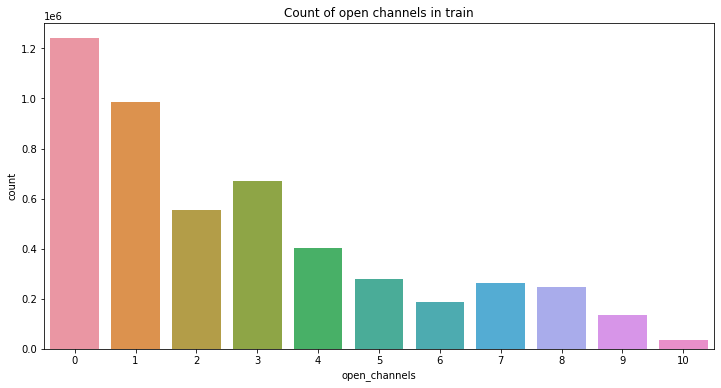

In [ ]:
# построим график для нашей целевой переменной 'open_channels'
fig, ax = plt.subplots(figsize=(12, 6))
sns.countplot(train['open_channels']).set(
    title='Count of open channels in train'
);

Видим, что присутствует дисбаланс в классах.

In [ ]:
train['open_channels'].value_counts()

0     1240152
1      985865
3      668609
2      553924
4      403410
5      277877
7      265015
8      245183
6      188112
9      136120
10      35733
Name: open_channels, dtype: int64

Теперь посмотрим на  изменение signal (колебание тока) с течением времени и то как изменяется количество открытых ионных каналов в зависимости от сигнала.

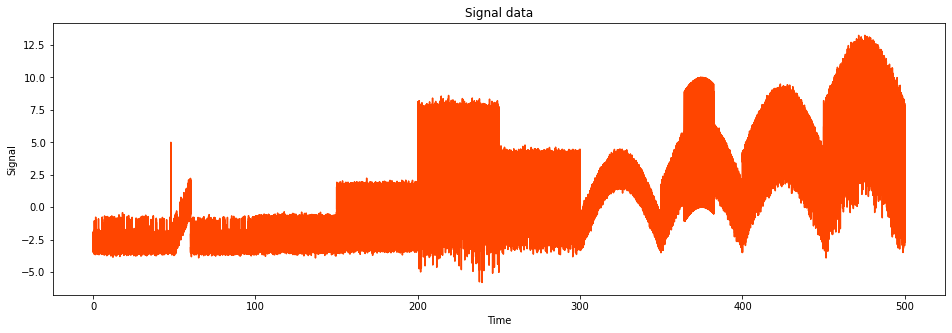

In [ ]:
# график распределения сигнала
plt.figure(figsize=(16, 5))
plt.plot(train["time"], train["signal"], color="orangered")
plt.title("Signal data", fontsize=12)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Signal", fontsize=10)
plt.show()

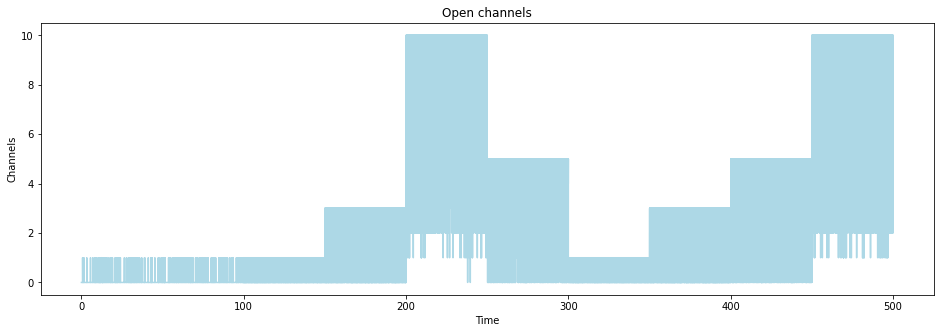

In [ ]:
# график количества открытых ионных каналов
plt.figure(figsize=(16, 5))
plt.plot(train["time"], train["open_channels"], color="lightblue")
plt.title("Open channels", fontsize=12)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Channels", fontsize=10)
plt.show()

Если сравнить эти два графика, то можно увидеть четкую взаимосвязть между сигналом и количеством каналов. По мере возрастания амплитуды сигнала возрастает и количество открытых каналов.

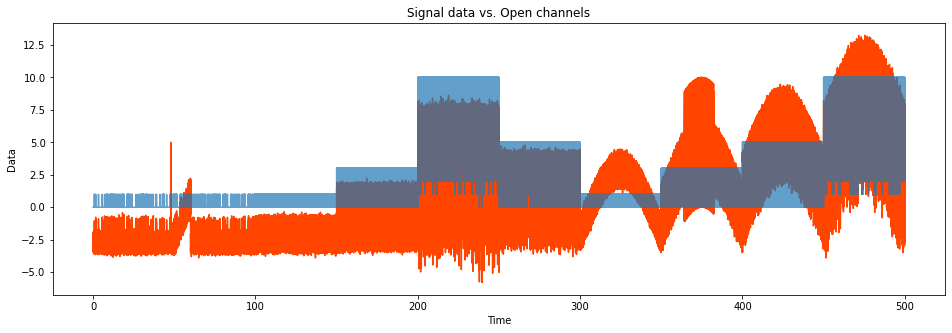

In [ ]:
plt.figure(figsize=(16, 5))
plt.plot(train["time"], train["signal"], color="orangered")
plt.plot(train["time"], train["open_channels"], alpha=0.7)
plt.title("Signal data vs. Open channels", fontsize=12)
plt.xlabel("Time", fontsize=10)
plt.ylabel("Data", fontsize=10)
plt.show()

Теперь для каждой серии данных построим график изменения сигнала и канала во времени. Как мы знаем из описания датасета одна серия ('batch') содержит 500 000 строк.

In [ ]:
train['batch'] = (train.index // 500000)

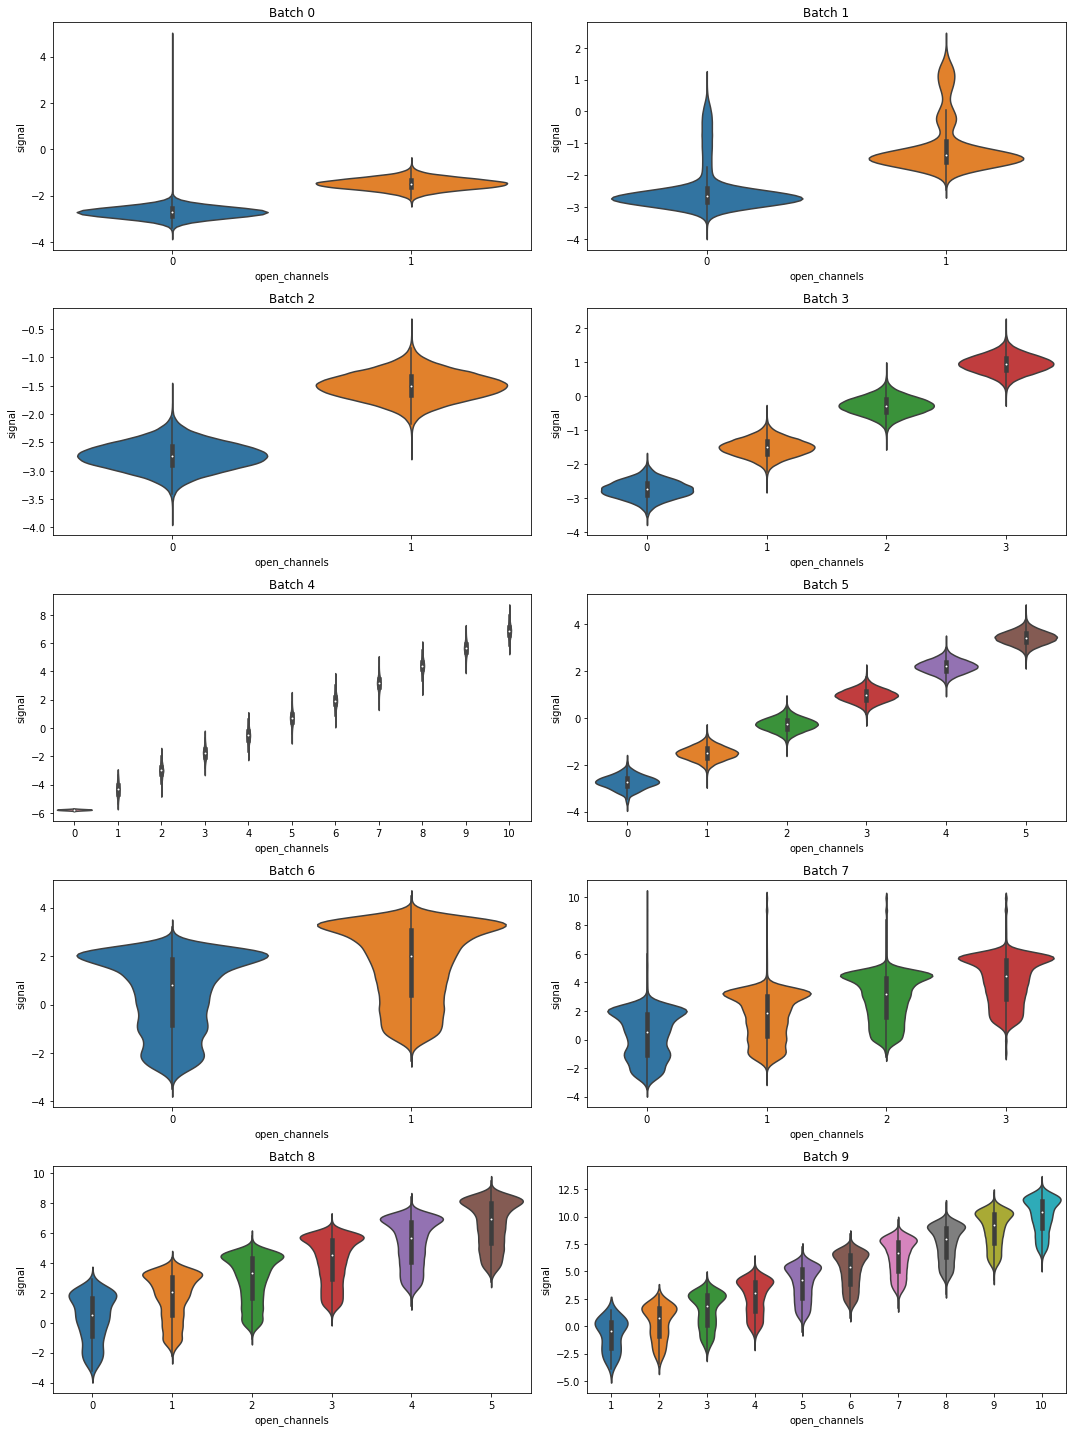

In [ ]:
fig, axs = plt.subplots(5, 2, figsize=(15, 20))
axs = axs.flatten()
i = 0
for batch, data in train.groupby("batch"):
    sns.violinplot(x="open_channels", y="signal", data=data, ax=axs[i])
    axs[i].set_title(f"Batch {batch:0.0f}")
    i += 1
plt.tight_layout()


Из приведенных выше графиков, мы видим, что есть схожие между собой группы ('batch'): 1-я(серия 0 и 1), 2-я(серии 2 и 6), 3-я(серии 3 и 7), 4-я(серии 5 и 8), 5-я(серии 4 и 9), где от 1-й к 5-й группе увеличивается количество открытых каналов. Возможно, есть смысл посторить отдельные модели для схожих групп, но в данном случае мы будем строить одну модель.


# Rolling

Попробуем применять к нашим временным рядам метод pandas: rolling. 




Создадим "окна" в тренировочном датасете. Тем самым создадим новые фичи.

In [4]:
#задаем размер "окон"
roll_size = [50, 100, 500, 1000, 5000, 10000, 50000]

for roll in roll_size:
    # вычисляем дисперсию, среднеквадратичное, среднеарифитическое
    # минимумы и максимумы
    train["rolling_mean_" + str(roll)] =\
    train["signal"].rolling(window=roll).mean()
    train["rolling_std_" + str(roll)] =\
    train["signal"].rolling(window=roll).std()
    train["rolling_var_" + str(roll)] =\
    train["signal"].rolling(window=roll).var()
    train["rolling_min_" + str(roll)] =\
    train['signal'].rolling(window=roll).min()
    train["rolling_max_" + str(roll)] =\
    train['signal'].rolling(window=roll).max()
    
    
train = train.replace([np.inf, -np.inf], np.nan)
train.fillna(0, inplace=True)


Тоже самое сделаем для тестовой выборки.

In [5]:
roll_size = [50, 100, 500, 1000, 5000, 10000, 50000]

for roll in roll_size:
    test["rolling_mean_" + str(roll)] =\
    test["signal"].rolling(window=roll).mean()
    test["rolling_std_" + str(roll)] =\
    test["signal"].rolling(window=roll).std()
    test["rolling_var_" + str(roll)] =\
    test["signal"].rolling(window=roll).var()
    test["rolling_min_" + str(roll)] =\
    test['signal'].rolling(window=roll).min()
    test["rolling_max_" + str(roll)] =\
    test['signal'].rolling(window=roll).max()
    
test = test.replace([np.inf, -np.inf], np.nan)
test.fillna(0, inplace=True)


# LGBMClassifier

В данном случае мы решаем задачу классификации (основываясь на macro F1 score). Построим нашу модель. Будем использовать LGBMClassifier

Выделим целевую переменную и разобъем данные на тренировочную и тестовую выборки.

In [6]:
X = train.drop(['open_channels'], axis=1)
y = train['open_channels']

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.20)

In [ ]:
X_train.shape, y_train.shape

((4000000, 37), (4000000,))

Т.к. классы несбалансированны, то добавим им веса. Вес класса обратно пропорционален количеству элементов класса. Для добавления большего веса используем экспоненту.

In [9]:
def class_weights(classes, exp=1):
   
    hist, _ = np.histogram(classes, bins=np.arange(12)-0.5)
    class_weight = hist.sum()/np.power(hist, exp)
    
    return class_weight

class_weight = class_weights(y_train)
print(class_weight)

[  4.03159155   5.07323854   9.02400837   7.476929    12.39610514
  17.98997958  26.53153273  18.86445418  20.40660154  36.79209706
 139.96290983]


Для примера работы RandomizedSearchCV, переберем пару параметров и произведем TimeSeriesSplit. 

In [18]:
params = {
          'max_depth': [7, 9],
          'n_estimators': [50, 100]
          }

In [19]:
tscv = TimeSeriesSplit(n_splits=3)

In [20]:
model_lgbweight = lgbm.LGBMClassifier()

In [23]:
rsh = RandomizedSearchCV(estimator=model_lgbweight,
                         param_distributions=params,
                         cv=tscv,
                         n_jobs=1, verbose=2)
rsh.fit(X_train, y_train)

/usr/local/lib/python3.6/dist-packages/sklearn/model_selection/_search.py:281: UserWarning: The total space of parameters 4 is smaller than n_iter=10. Running 4 iterations. For exhaustive searches, use GridSearchCV.
  % (grid_size, self.n_iter, grid_size), UserWarning)
[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


Fitting 3 folds for each of 4 candidates, totalling 12 fits
[CV] n_estimators=50, max_depth=7 ....................................
[CV] ..................... n_estimators=50, max_depth=7, total= 2.0min
[CV] n_estimators=50, max_depth=7 ....................................


[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:  2.0min remaining:    0.0s


[CV] ..................... n_estimators=50, max_depth=7, total= 3.6min
[CV] n_estimators=50, max_depth=7 ....................................
[CV] ..................... n_estimators=50, max_depth=7, total= 5.3min
[CV] n_estimators=100, max_depth=7 ...................................
[CV] .................... n_estimators=100, max_depth=7, total= 3.8min
[CV] n_estimators=100, max_depth=7 ...................................
[CV] .................... n_estimators=100, max_depth=7, total= 7.1min
[CV] n_estimators=100, max_depth=7 ...................................
[CV] .................... n_estimators=100, max_depth=7, total=10.4min
[CV] n_estimators=50, max_depth=9 ....................................
[CV] ..................... n_estimators=50, max_depth=9, total= 2.0min
[CV] n_estimators=50, max_depth=9 ....................................
[CV] ..................... n_estimators=50, max_depth=9, total= 3.8min
[CV] n_estimators=50, max_depth=9 ....................................
[CV] .

[Parallel(n_jobs=1)]: Done  12 out of  12 | elapsed: 66.1min finished


RandomizedSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=3),
                   error_score=nan,
                   estimator=LGBMClassifier(boosting_type='gbdt',
                                            class_weight=None,
                                            colsample_bytree=1.0,
                                            importance_type='split',
                                            learning_rate=0.1, max_depth=-1,
                                            min_child_samples=20,
                                            min_child_weight=0.001,
                                            min_split_gain=0.0,
                                            n_estimators=100, n_jobs=-1,
                                            num_leaves=31, objective=None,
                                            random_state=None, reg_alpha=0.0,
                                            reg_lambda=0.0, silent=True,
                                            subsample=

In [24]:
rsh.best_params_

{'max_depth': 9, 'n_estimators': 100}

In [25]:
preds = rsh.best_estimator_.predict(X_test)
print(metrics.f1_score(y_test, preds, average = 'macro'))

0.9192631142358899


In [26]:
# сохраняем модель
y_preds = rsh.predict(test)
sub["open_channels"] = y_preds
sub.to_csv("submission_lgbweight.csv", index=False, float_format="%.4f")

Построим confusion matrix на основе предсказаний модели.

In [16]:
# функция для отрисовки Confusion matrix
def plot_cm(y_test, preds, title):
    figsize = (12, 12)
    preds = preds.astype(int)
    cm = confusion_matrix(y_test, preds, labels=np.unique(y_test))
    cm_sum = np.sum(cm, axis=1, keepdims=True)
    cm_perc = cm / cm_sum.astype(float) * 100
    annot = np.empty_like(cm).astype(str)
    nrows, ncols = cm.shape
    for i in range(nrows):
        for j in range(ncols):
            c = cm[i, j]
            p = cm_perc[i, j]
            if i == j:
                s = cm_sum[i]
                annot[i, j] = "%.1f%%\n%d/%d" % (p, c, s)
            elif c == 0:
                annot[i, j] = ""
            else:
                annot[i, j] = "%.1f%%\n%d" % (p, c)
    cm = pd.DataFrame(cm, index=np.unique(y_test), columns=np.unique(y_test))
    cm.index.name = "Actual"
    cm.columns.name = "Predicted"
    fig, ax = plt.subplots(figsize=figsize)
    plt.title(title)
    sns.heatmap(cm, cmap="YlGnBu", annot=annot, square=True, fmt="", ax=ax)

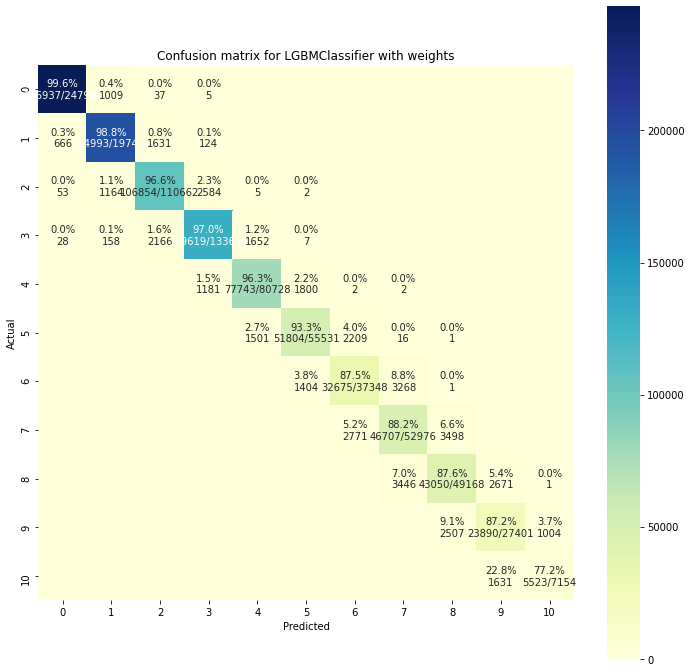

In [17]:
plot_cm(y_test, preds, 'Confusion matrix for LGBMClassifier with weights')

Результат модели: Public Score - 0.81494, Private Score - 0.77720.

Мы рассмотрели базовые принципы анализа данных: от предобработки данных до построения модели.
Научились, с помощью библиотек matplotlib и seaborn, строить графики и делать по ним выводы. 
Попробовали подобрать параметры, обучили модель и оценили ее качество.